In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
retail_df = pd.read_csv("C:\\Users\\Latitude\\Downloads\\online_retail.csv")

In [28]:
retail_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [57]:
print(retail_df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


In [53]:
retail_df.shape

(397924, 9)

In [55]:
print(retail_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB
None


In [56]:
print(retail_df.describe())

            Quantity                    InvoiceDate      UnitPrice  \
count  397924.000000                         397924  397924.000000   
mean       13.021823  2011-07-10 23:43:36.912475648       3.116174   
min         1.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 14:39:00       1.950000   
75%        12.000000            2011-10-20 14:33:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       180.420210                            NaN      22.096788   

          CustomerID     TotalPrice  
count  397924.000000  397924.000000  
mean    15294.315171      22.394749  
min     12346.000000       0.000000  
25%     13969.000000       4.680000  
50%     15159.000000      11.800000  
75%     16795.000000      19.800000  
max     18287.000000  168469.600000  
std      1713.169877     309.055588  


In [29]:
retail_df = retail_df.dropna(subset=['CustomerID'])

In [30]:
# Remove cancelled orders (InvoiceNo starting with 'C')
retail_df = retail_df[~retail_df['InvoiceNo'].astype(str).str.startswith('C')]

In [31]:
# Remove non-positive quantities
retail_df = retail_df[retail_df['Quantity'] > 0]

In [32]:
# Calculate total price per line
retail_df['TotalPrice'] = retail_df['Quantity'] * retail_df['UnitPrice']

In [33]:
# Ensure InvoiceDate is datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])

In [ ]:
# RFM calculation ----
snapshot_date = retail_df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [ ]:
# RFM calculation ----
snapshot_date = retail_df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = retail_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

In [ ]:
# Scoring ----
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [ ]:
#  Scoring ----
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

#  Segment mapping ----
def segment_me(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4:
        return 'Champions'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
        return 'Recent Customers'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 4:
        return 'At Risk'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_me, axis=1)


In [38]:
# ---- Step 6: Save the RFM table ----
rfm.to_csv("rfm_output.csv", index=False)


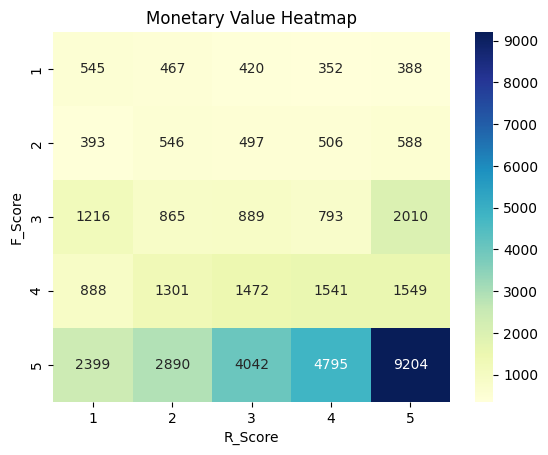

In [43]:
# Heatmap for RFM
rfm_pivot = rfm.pivot_table(index='F_Score', columns='R_Score', values='Monetary', aggfunc='mean')
sns.heatmap(rfm_pivot, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title("Monetary Value Heatmap")
plt.show()

C:\Users\Latitude\AppData\Local\Temp\ipykernel_10452\1834163493.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="viridis")


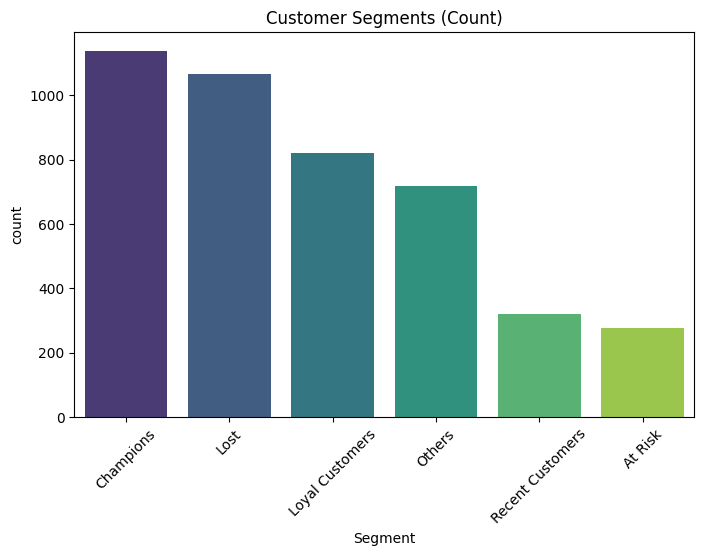

In [ ]:
# Visualization ----
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="viridis")
plt.title("Customer Segments (Count)")
plt.xticks(rotation=45)
plt.show()



C:\Users\Latitude\AppData\Local\Temp\ipykernel_10452\4164437769.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rfm, x='Segment', y='Monetary', order=rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=False).index, palette='coolwarm')


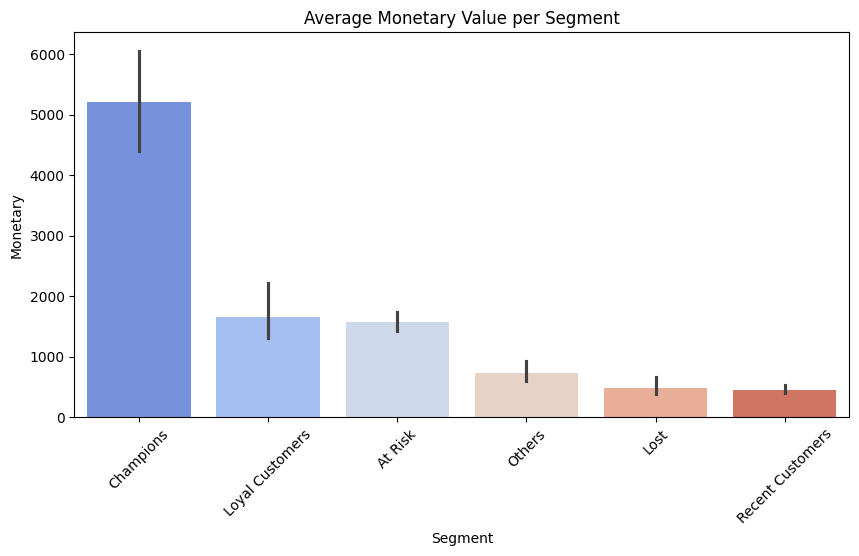

In [46]:
# 2. Average Monetary Value per Segment
plt.figure(figsize=(10,5))
sns.barplot(data=rfm, x='Segment', y='Monetary', order=rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=False).index, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Average Monetary Value per Segment")
plt.show()

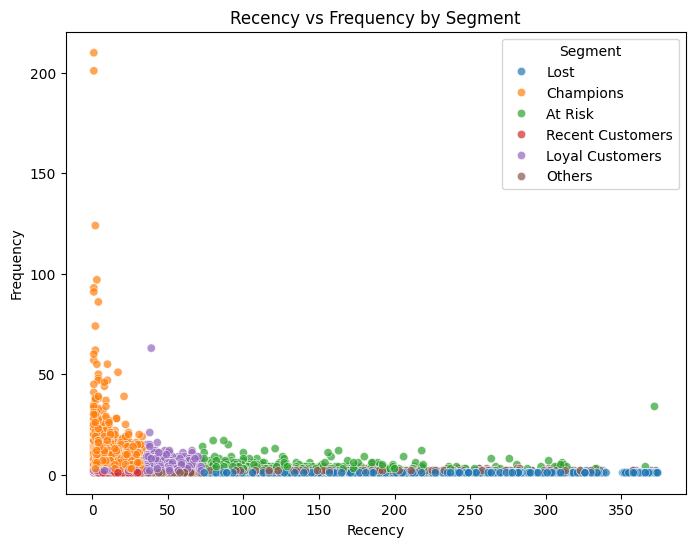

In [47]:
# 3. Recency vs Frequency Scatter
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='tab10', alpha=0.7)
plt.title("Recency vs Frequency by Segment")
plt.show()

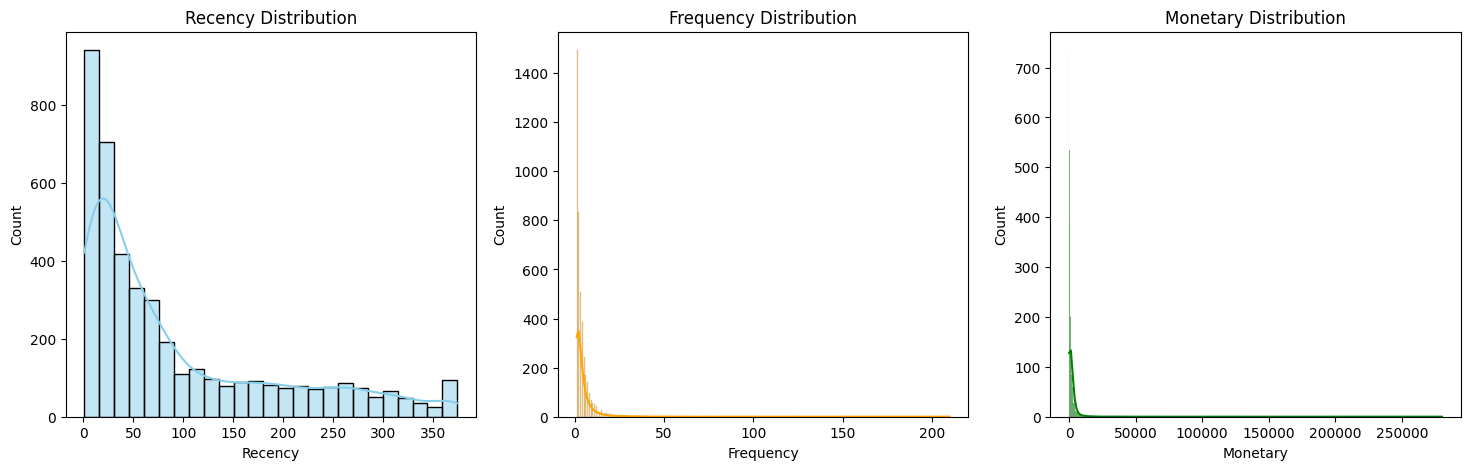

In [48]:
# 4. Distribution Plots
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(rfm['Recency'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Recency Distribution")
sns.histplot(rfm['Frequency'], kde=True, ax=axes[1], color='orange')
axes[1].set_title("Frequency Distribution")
sns.histplot(rfm['Monetary'], kde=True, ax=axes[2], color='green')
axes[2].set_title("Monetary Distribution")
plt.show()

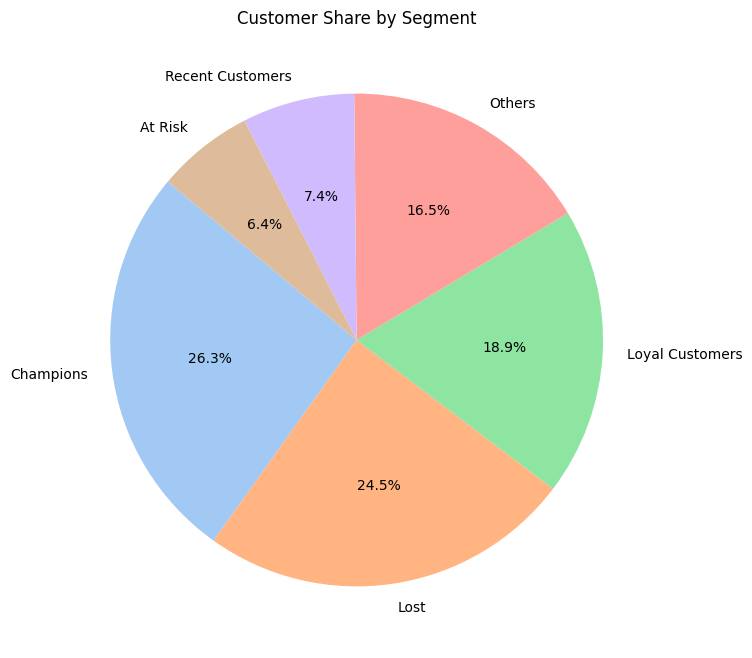

In [49]:
# 5. Pie Chart of Customer Share per Segment
segment_counts = rfm['Segment'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title("Customer Share by Segment")
plt.show()
